<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C6/C6.html"><img src="../data/C6_nav.png" width="100"  style="float:right;" alt="C6"></a>
<h1>Phase-Based Novelty</h1> 
</div>

<br/>

<p>
Following Section 6.1.3 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we introduce in this notebook a phase-based approach for computing a novelty function.   
</p> 

## Phase Representation

In the definition of the spectral-based novelty function, we have only used the magnitude of the spectral coefficients.  We now show how the phase information can be used for onset detection. In particular, we exploit the fact that stationary tones have a stable phase, while transients have an unstable phase. As usual, let $\mathcal{X}$ be the discrete STFT of the DT-signal $x$ using the sampling rate $F_\mathrm{s}$, the window length $N$, and the and the hop size $H$. Using the [**polar coordinate representation**](../C2/C2_ComplexNumbers.html), we write the complex coefficients $\mathcal{X}(n,k)\in\mathbb{C}$ as

\begin{equation}
   \mathcal{X}(n,k)= |\mathcal{X}(n,k)| \,\,\mathrm{exp}(2\pi i\varphi(n,k))
\end{equation}

with the phase $\varphi(n,k)\in[0,1)$. Intuitively, the phase $\varphi(n,k)$ determines how the sinusoid of frequency 
$F_\mathrm{coef}(k)= F_\mathrm{s}\cdot k/N$ has to be shifted to best correlate with the windowed signal corresponding to the $n^{\mathrm{th}}$ frame. Let us assume that the signal $x$ has a high correlation with this sinusoid (i.e., $|\mathcal{X}(n,k)|$ is large) and shows a steady behavior in a region of a number of subsequent frames $\ldots,n-2,n-1,n,n+1,\ldots$ (i.e., $x$ is locally stationary). Then the phases $\ldots,\varphi(n-2,k)$, $\varphi(n-1,k)$, $\varphi(n,k)$, $\varphi(n+1,k),\ldots$ increase from frame to frame in a fashion that is linear in the hop size $H$ of the STFT. Therefore, the frame-wise phase difference in this region remains approximately constant:

\begin{equation}
   \varphi(n,k)- \varphi(n-1,k)  \approx \varphi(n-1,k)- \varphi(n-2,k).
\end{equation}

This is illustrated by the following figure, where the angular representation of the phases is indicated by the circles.

<img src="../data/C6/FMP_C6_F08.png" width="300px" align="middle" alt="FMP_C6_F08.png">

## Principal Argument Function

When one considers phase differences, one needs to take care of **phase wrapping** discontinuities that are due to the fact that the phase is periodic. Besides **phase unwrapping** strategies, another alternative is to use the **principal argument function** 

\begin{equation}
        \Psi:\mathbb{R}\to\left[-0.5,0.5\right]
\end{equation}

which maps phase differences into the range $[-0.5,0.5]$. To this end, a suitable integer value is added to or subtracted from the original phase difference to yield a value in $[-0.5,0.5]$. 

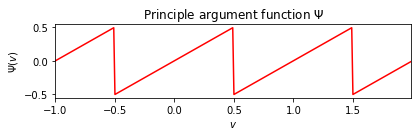

In [1]:
import numpy as np
import os, sys, librosa
from scipy import signal
from matplotlib import pyplot as plt
import IPython.display as ipd

sys.path.append('..')
import LibFMP.B
import LibFMP.C2
import LibFMP.C6
from LibFMP.C6 import compute_local_average

%matplotlib inline

def principal_argument(v):
    """Principal argument function 
    
    Notebook: /C6/C6S1_NoveltyPhase.ipynb, see also C8/C8S2_InstantFreqEstimation.ipynb
    
    Args:
        v: value (or vector of values)
        
    Returns:
        w: Principle value of v
    """
    w = np.mod(v + 0.5, 1) - 0.5
    return w

v = np.arange(-1,2,0.01)

plt.figure(figsize=(6,2))
plt.plot(v, principal_argument(v), 'r')
plt.title(r'Principle argument function $\Psi$')
plt.xlabel(r'$v$')
plt.ylabel(r'$\Psi(v)$')
plt.xlim([v[0], v[-1]])
plt.tight_layout()

## Phase-Based Novelty Function

Using the principle argument function, we define the **first-order phase difference** and **second-order phase difference** by 

\begin{eqnarray}
\label{eq:BeatTempo:Onset:Phase:Wrapping:PhaseDiff1}
   \varphi'(n,k) &:=& \Psi\big(\varphi(n,k)- \varphi(n-1,k)\big), \\
   \varphi''(n,k) &:=& \Psi\big(\varphi'(n,k)- \varphi'(n-1,k)\big).
\end{eqnarray}

As mentioned above, frame-wise phase differences remain approximately constant in steady regions of $x$, which implies $\varphi''(n,k)\approx 0$. However, in transient regions, the phase behaves quite unpredictably across the entire frequency range. As a result, a simultaneous disturbance of the values $\varphi''(n,k)$ for $k\in[0:K]$ is a good indicator for note onsets. Motivated by this observation, we define the **phase-based novelty function** $\Delta_\mathrm{Phase}$ by

\begin{equation}
   \Delta_\mathrm{Phase}(n) = \sum_{k=0}^{K} |\varphi''(n,k)|
\end{equation}

for $n\in\mathbb{Z}$. Note that using the principal argument function takes care of discontinuities due to phase wrapping. On the downside, the principal argument function may also cancel out large discontinuities in the phase differences that are due to note onsets. However, this effect is attenuated since we will consider the sum of phase differences over all frequency indices.

## Implementation

In the following code cell, one finds an implementation for computing a phase-based novelty function. As for the [spectral-based novelty function](../C6/C6S1_NoveltySpectral.html), one may further post-process the novelty curve by subtracting a local average and by dividing the curve by its maximum value.  

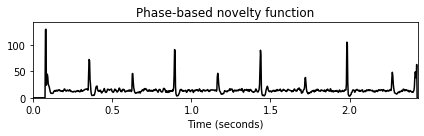

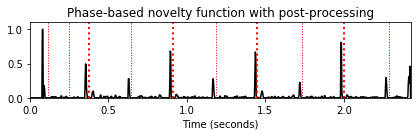

In [2]:
def compute_novelty_phase(x, Fs=1, N=1024, H=64, M=40, norm=1):
    """Compute phase-based novelty function

    Notebook: C6/C6/C6S1_NoveltyPhase.ipynb

    Args:
        x: Signal
        Fs: Sampling rate
        N: Window size
        H: Hop size
        M: Determines size (2M+1) in samples of centric window  used for local average
        norm: Apply max norm (if norm==1)

    Returns:
        novelty_spectrum: Energy-based novelty function
        Fs_feature: Feature rate
    """     
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hanning')
    Fs_feature = Fs/H
    phase = np.angle(X)/(2*np.pi)
    phase_diff = principal_argument(np.diff(phase, axis=1))
    phase_diff2 = principal_argument(np.diff(phase_diff, axis=1))
    novelty_phase = np.sum(np.abs(phase_diff2), axis=0)
    novelty_phase = np.concatenate( (novelty_phase, np.array([0, 0])) )    
    if M > 0:
        local_average = compute_local_average(novelty_phase, M)
        novelty_phase =  novelty_phase - local_average
        novelty_phase[novelty_phase<0]=0
    if norm==1: 
        max_value = np.max(novelty_phase)
        if max_value > 0:
            novelty_phase = novelty_phase / max_value
    return novelty_phase, Fs_feature

fn_ann = os.path.join('..', 'data', 'C6', 'FMP_C6_F01_Queen.csv')
ann, label_keys = LibFMP.C6.read_annotation_pos(fn_ann)

fn_wav = os.path.join('..', 'data', 'C6', 'FMP_C6_F01_Queen.wav')
Fs = 22050
x, Fs = librosa.load(fn_wav, Fs)
x_duration = len(x)/Fs

nov, Fs_nov = compute_novelty_phase(x, Fs=Fs, M=0, norm=0) 
LibFMP.B.plot_signal(nov, Fs_nov, color='k', 
    title='Phase-based novelty function');

nov, Fs_nov = compute_novelty_phase(x, Fs=Fs, M=10, norm=1) 
fig, ax, line = LibFMP.B.plot_signal(nov, Fs_nov, color='k', 
                    title='Phase-based novelty function with post-processing')
LibFMP.B.plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                    nontime_axis=True, time_min=0, time_max=x_duration);

## Role of Hopsize Parameter

In general, phase-based approaches are quite sensitive with regard to the hopsize. In particular, when using a large hopsize, the prediction of the phase over subsequent frames often become inaccurate. Therefore, in phase-based approaches, choosing a **small hopsize**  is often beneficial. This phenomenon is also illustrated by the following example.

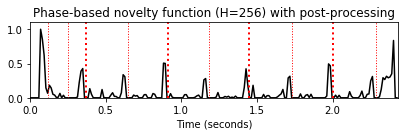

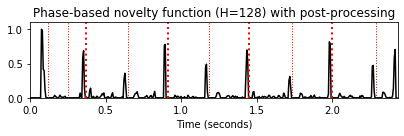

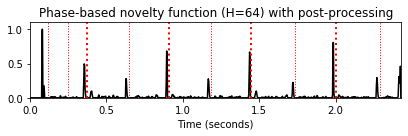

In [3]:
H_set = [256, 128, 64]

for H in H_set:
    nov, Fs_nov = compute_novelty_phase(x, Fs=Fs, N=1024, H=H, M=10, norm=1)
    fig, ax, line = LibFMP.B.plot_signal(nov, Fs_nov, color='k',
                        title='Phase-based novelty function (H=%d) with post-processing'%H)
    LibFMP.B.plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                        nontime_axis=True, time_min=0, time_max=x_duration);

## Further Notes

* In the [FMP notebook on onset detection](../C6/C6S1_OnsetDetection.html), one finds an introduction to the task of onset detection. 
* In the [FMP notebook on novelty comparison](../C6/C6S1_NoveltyComparison.html), we compare different novelty detection approaches.

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and Angel Villar-Corrales.
</div> 

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>